In [1]:
import numpy as np
import pandas as pd
import numpy.linalg as la
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import tensorflow as tf

/Users/deancasey/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


***Problem 2:***

In [2]:
class Distribution:
    def __init__(self,X):
        self.mean = np.mean(X,axis=0)
        self.cov = np.cov(X)

In [3]:
def matrix_sqrt(X):
    eigvals, eigvecs = la.eigh(X)
    sqrt_eigvals = np.sqrt(np.maximum(eigvals, 0))
    sqrt_X = eigvecs @ np.diag(sqrt_eigvals) @ eigvecs.T
    return sqrt_X

In [4]:
def FID(P_g, P_d):
    mean_g = P_g.mean
    mean_d = P_d.mean
    
    if P_g.cov.shape == ():
        cov_g = P_g.cov.reshape(-1,1)
        cov_d = P_d.cov.reshape(-1,1)
    else:
        cov_g = P_g.cov
        cov_d = P_d.cov
        
    sqrt_cov_g = matrix_sqrt(cov_g)

    mean_dist = la.norm(mean_g-mean_d)**2
    print(mean_dist)
        
    weird_term = sqrt_cov_g @ cov_d @ sqrt_cov_g
    sqrt_prod = matrix_sqrt(weird_term)

    tr_terms = cov_g + cov_d - 2*sqrt_prod
    tr = np.matrix.trace(tr_terms)
    print(tr)
    
    return mean_dist + tr

In [5]:
mnist_data = np.load('/Users/deancasey/Downloads/MNIST_data.npy')
mnist_labels = np.load('/Users/deancasey/Downloads/MNIST_labels.npy')
mnist_data.shape, mnist_labels.shape

((70000, 784), (70000,))

In [6]:
sample0 = Distribution(mnist_data[0])
sample1 = Distribution(mnist_data[1])

In [7]:
FID(sample0,sample1)

20.73501275510206
17.986380930500673


38.721393685602735

In [8]:
samp1_set = Distribution(mnist_data[:100])
samp2_set = Distribution(mnist_data[100:200])

In [9]:
FID(samp1_set,samp2_set)

63016.970400000006
318598.21893440746


381615.18933440745

***Problem 3***

Code derived heavily from: https://medium.com/@sofeikov/implementing-variational-autoencoders-from-scratch-533782d8eb95

In [10]:
def show_images(images, labels):
    """
    Display a set of images and their labels using matplotlib.
    The first column of `images` should contain the image indices,
    and the second column should contain the flattened image pixels
    reshaped into 28x28 arrays.
    """
    # Extract the image indices and reshaped pixels
    pixels = images.reshape(-1, 28, 28)
    #labels = labels.reshape(-1,1)

    # Create a figure with subplots for each image
    fig, axs = plt.subplots(
        ncols=len(images), nrows=1, figsize=(10, 3 * len(images))
    )

    # Loop over the images and display them with their labels
    for i in range(len(images)):
        # Display the image and its label
        axs[i].imshow(pixels[i], cmap="gray")
        axs[i].set_title("Label: {}".format(labels[i]))

        # Remove the tick marks and axis labels
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        axs[i].set_xlabel("Index: {}".format(i))

    # Adjust the spacing between subplots
    fig.subplots_adjust(hspace=0.5)

    # Show the figure
    plt.show()

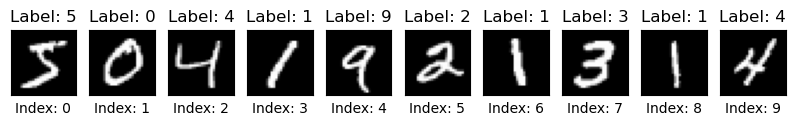

In [11]:
show_images(mnist_data[:10],mnist_labels[:10])

In [12]:
def get_mnist(train_dat_size=10000):

    data=np.float64(mnist_data)
    labels=np.float32(mnist_labels)
    print(data.shape)
    n = data.shape[0]
    len_val_test = n-train_dat_size
    half = len_val_test//2
    data=np.float32(data)/255

    train_dat=data[0:train_dat_size]
    train_labels=np.int32(labels[0:train_dat_size])
    val_dat=data[train_dat_size:train_dat_size+half]
    val_labels=np.int32(labels[train_dat_size:train_dat_size+half])
    test_dat=data[train_dat_size+half:n]
    test_labels=np.int32(labels[train_dat_size+half:n])

    return (train_dat, train_labels), (val_dat, val_labels), (test_dat, test_labels)

In [13]:
(X_train, y_train), (X_val, y_val), (X_test, y_test) = get_mnist()

X_train = X_train.astype(np.float32) 
X_val = X_val.astype(np.float32)
X_test = X_test.astype(np.float32)


y_train = y_train.astype(np.int64)
y_val = y_val.astype(np.int64)
y_test = y_test.astype(np.int64)

(70000, 784)


In [14]:
class AutoEncoder(nn.Module):
    def __init__(self,h=8,d=256):
        super().__init__()
        
        self.num_hidden = h
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(784, d),  # input size: 784, output size: d
            nn.ReLU(), 
            nn.Linear(d, self.num_hidden),  # input size: d, output size: num_hidden
            nn.ReLU(), 
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(self.num_hidden, d),  # input size: num_hidden, output size: d
            nn.ReLU(),
            nn.Linear(d, 784),  # input size: d, output size: 784
            nn.Sigmoid(), 
        )

    def forward(self, x):
        encoded = self.encoder(x)
        
        decoded = self.decoder(encoded)
        return encoded, decoded

In [15]:
learning_rate = 1e-3
batch_size = 1000
num_epochs = 200

# Convert the training data to PyTorch tensors
X_train = torch.from_numpy(X_train)
X_val = torch.from_numpy(X_val)
X_test = torch.from_numpy(X_test)


# Create the autoencoder model and optimizer
model = AutoEncoder(h=8,d=256)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define the loss function
criterion = nn.MSELoss()

# Set the device to GPU if available, otherwise use CPU
# model.to(device)

# Create a DataLoader to handle batching of the training data
train_loader = torch.utils.data.DataLoader(
    X_train, batch_size=batch_size, shuffle=True
)

In [16]:
# class Bernoulli:
#     def __init__(self, min_prob=0.01, max_prob=0.99):
#         self.min_prob = min_prob
#         self.max_prob = max_prob

#     def __call__(self, O):
#         pi = torch.sigmoid(O)
#         pi = torch.clamp(pi, min=self.min_prob, max=self.max_prob)
#         return pi

# bernoulli_dist = Bernoulli()

In [17]:
class VAE(AutoEncoder):
    def __init__(self,h=8,d=256):
        super().__init__(h=h,d=d)
        # Add mu and log_var layers for reparameterization
        self.mu = nn.Linear(self.num_hidden, self.num_hidden)
        self.log_var = nn.Linear(self.num_hidden, self.num_hidden)

    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var)
        # Generate random noise using the same shape as std
        eps = torch.randn_like(std)
        # Return the reparameterized sample
        return mu + eps * std

    def forward(self, x):
        # Pass the input through the encoder
        encoded = self.encoder(x)
        # Compute the mean and log variance vectors
        mu = self.mu(encoded)
        log_var = self.log_var(encoded)
        # Reparameterize the latent variable
        z = self.reparameterize(mu, log_var)
        # Pass the latent variable through the decoder
        decoded = self.decoder(z)
        # Return the encoded output, decoded output, mean, and log variance
        return encoded, decoded, mu, log_var

    def sample(self, num_samples):
        with torch.no_grad():
            # Generate random noise
            z = torch.randn(num_samples, self.num_hidden)#.to(device)
            # Pass the noise through the decoder to generate samples
            samples = self.decoder(z)
        # Return the generated samples
        return samples

In [18]:
def loss_function(recon_x, x, mu, logvar):
    # Compute binary cross-entropy loss between the reconstructed output and the input data
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction="sum")
    
    # Compute the Kullback-Leibler divergence
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    # Apply torch.clamp to avoid degeneracies as instructed
    recon_x = torch.clamp(recon_x, 1e-6, 1 - 1e-6)
    
    # Compute the negative log likelihood of the data given the reconstructed output
    NLL = -torch.sum(x * torch.log(recon_x) + (1 - x) * torch.log(1 - recon_x))
    loss = BCE + 0.5 * KLD + NLL
    
    return loss


In [20]:
def train_vae(X_train, h=8,d=256,learning_rate=1e-3, num_epochs=200, batch_size=1000):

    # Create the autoencoder model and optimizer
    model = VAE(h=h,d=d)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Define the loss function
    criterion = nn.MSELoss(reduction="sum")

    # Create a DataLoader to handle batching of the training data
    train_loader = torch.utils.data.DataLoader(
        X_train, batch_size=batch_size, shuffle=True
    )

    # Training loop
    for epoch in range(num_epochs):
        total_loss = 0.0
        for batch_idx, data in enumerate(train_loader):
            # Get a batch of training data and move it to the device
            #data = data.to(device)

            # Forward pass
            encoded, decoded, mu, log_var = model(data)

            # Compute the loss and perform backpropagation
            KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            loss = criterion(decoded, data) + 3 * KLD
            
            #loss = loss_function(decoded,data,mu,log_var)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update the running loss
            total_loss += loss.item() * data.size(0)

        # Print the epoch loss
        epoch_loss = total_loss / len(train_loader.dataset)
        #print(
            #"Epoch {}/{}: loss={:.4f}".format(epoch + 1, num_epochs, epoch_loss)
        #)

    # Return the trained model
    return model, epoch_loss

In [21]:
trained_vae, final_loss = train_vae(X_train)
trained_vae

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=8, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=8, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=784, bias=True)
    (3): Sigmoid()
  )
  (mu): Linear(in_features=8, out_features=8, bias=True)
  (log_var): Linear(in_features=8, out_features=8, bias=True)
)

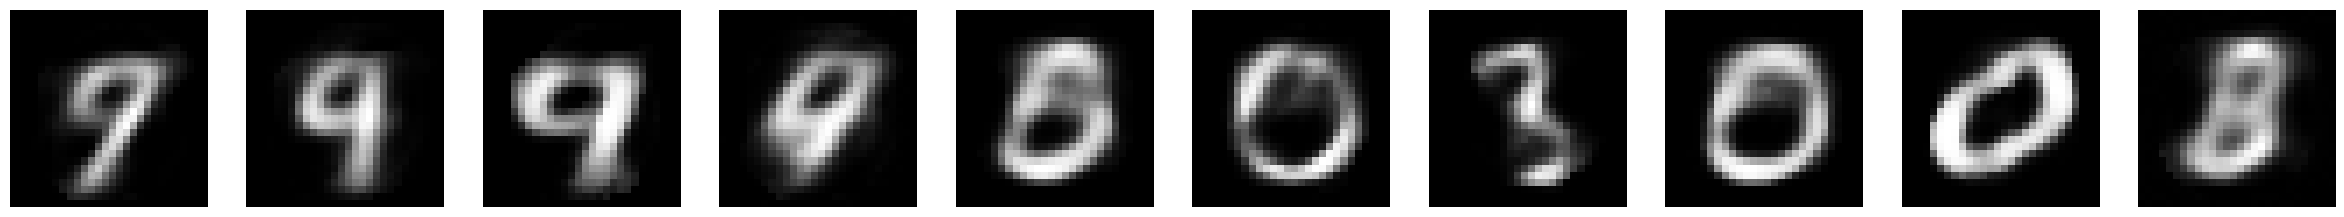

In [22]:
def generate_images(model, num_images=10, latent_dim=8):
    # Generate random latent vectors
    latent_vectors = torch.randn(num_images, latent_dim)
    
    # Decode the latent vectors
    with torch.no_grad():
        decoded_images = model.decoder(latent_vectors)
    
    # Visualize the reconstructed images
    fig, axs = plt.subplots(1, num_images, figsize=(num_images * 3, 3))
    for i in range(num_images):
        axs[i].imshow(decoded_images[i].cpu().numpy().reshape(28, 28), cmap='gray')
        axs[i].axis('off')
    plt.show()
    
generate_images(trained_vae, num_images=10)

In [23]:
trained_vae

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=8, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=8, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=784, bias=True)
    (3): Sigmoid()
  )
  (mu): Linear(in_features=8, out_features=8, bias=True)
  (log_var): Linear(in_features=8, out_features=8, bias=True)
)

In [24]:
X_val[0].shape

torch.Size([784])

Part b)

In [25]:
def test_single_sample(vae_model, test_sample):

    encoded, decoded, mu, log_var = vae_model(test_sample)        
    return decoded

test_sample = X_val[0].view(1, -1)
reconstructed_sample0 = test_single_sample(trained_vae, test_sample)

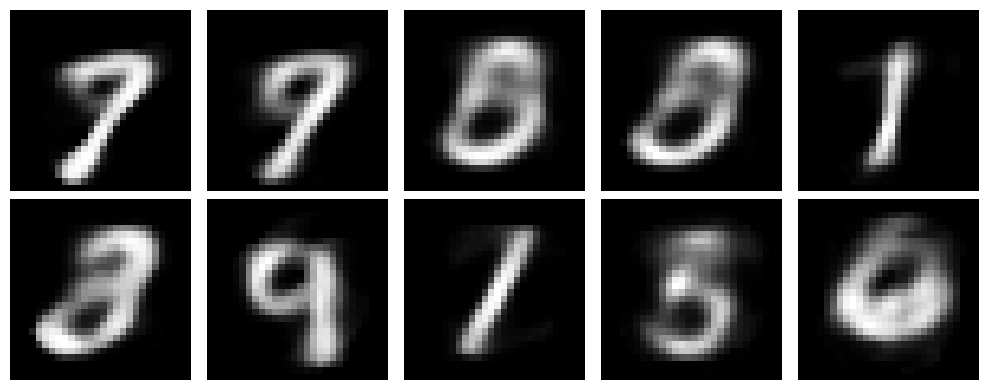

In [26]:
def display_samples(samples, labels, n_rows=2, n_cols=5,image_size=(28, 28)):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 4))
    for i, ax in enumerate(axes.flat):
        # Detach the sample from the computation graph and convert it to a NumPy array
        sample = samples[i].detach().cpu().numpy()
        # Reshape the sample to the original image dimensions
        sample = sample.reshape(28, 28)
        # Display the reconstructed sample as a grayscale image
        ax.imshow(sample, cmap='gray')
        ax.axis('off')
        #ax.set_title(f'Label: {labels[i]}')
    plt.tight_layout()
    plt.show()

reconstructed_samples = []
original_images = []
for i in range(10):
    test_sample = X_test[i].view(1, -1)
    reconstructed_sample = test_single_sample(trained_vae, test_sample)
    reconstructed_samples.append(reconstructed_sample)
    original_images.append(X_test[i])

display_samples(reconstructed_samples, y_test[:10])

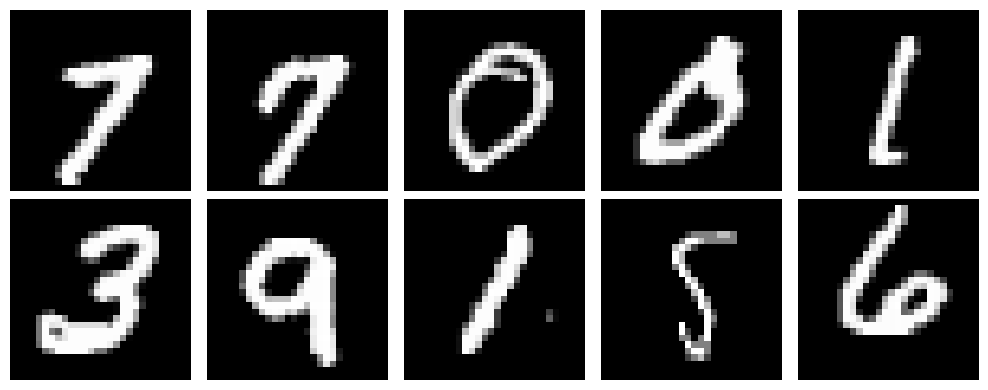

In [27]:
display_samples(original_images, y_test[:10])

Problem c)

Decoder input shape: torch.Size([100, 8])


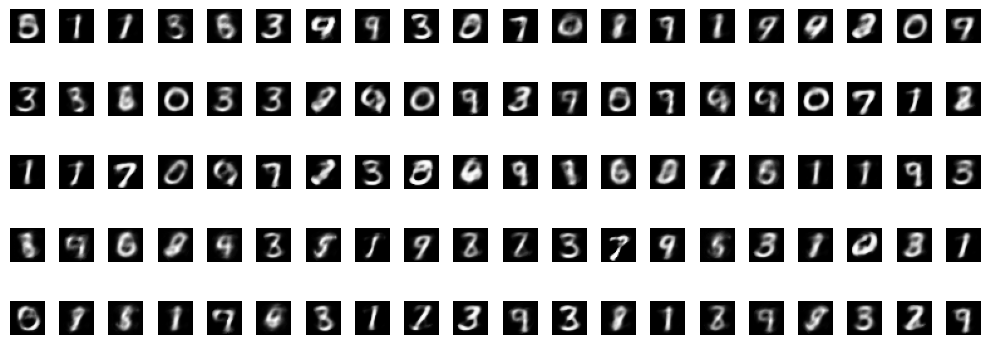

In [28]:
def generate_samples(vae_model, num_samples, latent_dim=8):
    # Sample from the standard normal distribution Z
    z = torch.randn(num_samples, latent_dim)
    
    # Pass a dummy input through the encoder to determine its output size
    with torch.no_grad():
        dummy_input = torch.zeros(1, vae_model.encoder[0].in_features)
        encoder_output = vae_model.encoder(dummy_input)
        num_features = encoder_output.size(1)
    
    # Pass the samples through the decoder to generate images
    with torch.no_grad():
        decoder_input = torch.cat((z, torch.zeros(num_samples, num_features - latent_dim)), dim=1)
        print("Decoder input shape:", decoder_input.shape)
        generated_samples = vae_model.decoder(decoder_input)
    
    return generated_samples

generated_samples = generate_samples(trained_vae, 100)

display_samples(generated_samples, labels=None, n_rows=5, n_cols=20)

Problem d)

In [30]:
class Distribution_torch:
    def __init__(self, samples):
        self.samples = samples
    
    def compute_mean(self):
        return torch.mean(self.samples, dim=0)
    
    def compute_covariance(self):
        mean_centered = self.samples - self.compute_mean()
        return torch.matmul(mean_centered.T, mean_centered) / len(self.samples)

Couldn't get spectral decomposition to work with the tensors, so using SVD instead.

In [32]:
def FID_torch(P_g, P_d):
    mean_g = P_g.compute_mean()
    mean_d = P_d.compute_mean()
    
    epsilon = 1e-6
    
    if P_g.compute_covariance().ndim == 0:
        cov_g = P_g.compute_covariance().view(-1, 1)
        cov_d = P_d.compute_covariance().view(-1, 1)
    else:
        cov_g = P_g.compute_covariance()
        cov_d = P_d.compute_covariance()
        
    cov_g_reg = cov_g + torch.eye(cov_g.shape[0]) * epsilon
    cov_d_reg = cov_d + torch.eye(cov_d.shape[0]) * epsilon
    
    sqrt_cov_g_reg = torch.linalg.svd(cov_g_reg).U

    mean_dist = torch.norm(mean_g - mean_d)**2
        
    # Regularize the matrix product to ensure positive-definiteness
    weird_term = sqrt_cov_g_reg @ cov_d_reg @ sqrt_cov_g_reg.T + epsilon * torch.eye(cov_g.shape[0])
    sqrt_prod = torch.linalg.svd(weird_term).U

    tr_terms = cov_g + cov_d - 2 * sqrt_prod
    tr = torch.trace(tr_terms)
    
    return mean_dist + tr


In [33]:
# random_test = torch.randn(100, 784).numpy()

# # Compute FID score
# P_g = Distribution(generated_data)
# P_d = Distribution(random_test)
# fid_score = FID(P_g, P_d)

# print("FID Score:", fid_score)

In [35]:
generated_samples = generate_samples(trained_vae, 100)
generated_samples_np = generated_samples.numpy()

generated_distribution = Distribution_torch(generated_samples)
generated_mean = generated_distribution.compute_mean()
generated_cov = generated_distribution.compute_covariance()
    
test_distribution = Distribution_torch(X_val[:100])
test_mean = test_distribution.compute_mean()
test_cov = test_distribution.compute_covariance()
    
fid_score = FID_torch(generated_distribution, test_distribution).item()

Decoder input shape: torch.Size([100, 8])


In [36]:
fid_score

82.84440612792969

In [37]:
def compute_num_parameters(model):
    enc_first_lin_layer = (model.encoder[0].in_features + 1) * model.encoder[0].out_features
    enc_sec_lin_layer = (model.encoder[2].in_features + 1) * model.encoder[2].out_features
    
    dec_first_lin_layer = (model.decoder[0].in_features + 1) * model.encoder[0].out_features
    dec_sec_lin_layer = (model.decoder[2].in_features + 1) * model.encoder[2].out_features
    
    return enc_first_lin_layer + enc_sec_lin_layer + dec_first_lin_layer + dec_sec_lin_layer

In [38]:
compute_num_parameters(AutoEncoder(h=256,d=8))

12944

In [39]:
def generate_samples2(vae_model, num_samples, latent_dim=8):
    # Sample from the standard normal distribution Z
    z = torch.randn(num_samples, latent_dim)
    
    # Get the output size of the first linear layer in the decoder
    num_features = vae_model.decoder[0].in_features
    
    # Pass the samples through the decoder to generate images
    with torch.no_grad():
        decoder_input = torch.cat((z, torch.zeros(num_samples, num_features - latent_dim)), dim=1)
        print("Decoder input shape:", decoder_input.shape)
        generated_samples = vae_model.decoder(decoder_input)
    
    return generated_samples


In [40]:
def VAE_FID_test(h=256,d=8,num_epochs=200):
    # Train - Test - Split:
    (X_train, y_train), (X_val, y_val), (X_test, y_test) = get_mnist()
    X_train = X_train.astype(np.float32) 
    X_val = X_val.astype(np.float32)
    X_test = X_test.astype(np.float32)
    y_train = y_train.astype(np.int64)
    y_val = y_val.astype(np.int64)
    y_test = y_test.astype(np.int64)
    
    num_samples = 1000
    
    trained_vae, final_loss = train_vae(X_train,h=h,d=d,num_epochs=num_epochs)
    
    generated_samples = generate_samples2(trained_vae, num_samples, latent_dim=d)
    generated_samples_np = generated_samples.numpy()
    generated_distribution = Distribution_torch(generated_samples)
    generated_mean = generated_distribution.compute_mean()
    generated_cov = generated_distribution.compute_covariance()
    
    val_distribution = Distribution_torch(torch.tensor(X_val[:100]))
    val_mean = val_distribution.compute_mean()
    val_cov = val_distribution.compute_covariance()
    
    fid_score = FID_torch(generated_distribution, val_distribution).item()
    
    num_params = compute_num_parameters(trained_vae)
    
    return num_params, final_loss, fid_score
    

In [41]:
num_params_128_10, final_loss_128_10, fid_score_128_10 = VAE_FID_test(h=128,d=10)

(70000, 784)
Decoder input shape: torch.Size([1000, 128])


In [42]:
num_params_128_10, final_loss_128_10, fid_score_128_10

(11956, 51634.425, 57.648193359375)

In [43]:
num_params_256_10, final_loss_256_10, fid_score_256_10 = VAE_FID_test(h=256,d=10)

(70000, 784)
Decoder input shape: torch.Size([1000, 256])


In [44]:
num_params_256_10, final_loss_256_10, fid_score_256_10

(16052, 53067.513671875, 53.97014236450195)

In [46]:
num_params_512_10, final_loss_512_10, fid_score_512_10 = VAE_FID_test(h=512,d=10,num_epochs=50)

(70000, 784)
Decoder input shape: torch.Size([1000, 512])


In [47]:
num_params_512_10, final_loss_512_10, fid_score_512_10

(24244, 63757.588671875, 131.24600219726562)

In [48]:
num_params_128_40, final_loss_128_40, fid_score_128_40 = VAE_FID_test(h=128,d=40,num_epochs=50)

(70000, 784)
Decoder input shape: torch.Size([1000, 128])


In [49]:
num_params_128_40, final_loss_128_40, fid_score_128_40

(47056, 53729.773046875, 61.67253112792969)

In [50]:
num_params_128_40, final_loss_128_40, fid_score_128_40 = VAE_FID_test(h=128,d=40,num_epochs=50)

(70000, 784)
Decoder input shape: torch.Size([1000, 128])


In [51]:
num_params_128_40, final_loss_128_40, fid_score_128_40

(47056, 53686.52890625, 68.1171875)

In [52]:
num_params_256_40, final_loss_256_40, fid_score_256_40 = VAE_FID_test(h=256,d=40,num_epochs=50)

(70000, 784)
Decoder input shape: torch.Size([1000, 256])


In [53]:
num_params_256_40, final_loss_256_40, fid_score_256_40

(62672, 55113.97421875, 76.55585479736328)

In [54]:
num_params_512_40, final_loss_512_40, fid_score_512_40 = VAE_FID_test(h=512,d=40,num_epochs=50)

(70000, 784)
Decoder input shape: torch.Size([1000, 512])


In [55]:
num_params_512_40, final_loss_512_40, fid_score_512_40

(93904, 57717.575390625, 90.86860656738281)

There seems to be somewhat of an inverse correlation between Validation loss and the FID Score.

In [72]:
trained_ae = AutoEncoder()
optimizer = optim.Adam(trained_ae.parameters(), lr=learning_rate)

# Define the loss function
criterion = nn.MSELoss()

# Create a DataLoader to handle batching of the training data
train_loader = torch.utils.data.DataLoader(
    X_train, batch_size=batch_size, shuffle=True
)

In [73]:
num_epochs=100
for epoch in range(num_epochs):
    total_loss = 0.0
    for batch_idx, data in enumerate(train_loader):
        # Forward pass
        encoded, decoded = trained_ae(data)

        # Compute the loss and perform backpropagation
        loss = criterion(decoded, data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update the running loss
        total_loss += loss.item() * data.size(0)

    # Print the epoch loss
    epoch_loss = total_loss / len(train_loader.dataset)
    print(
        "Epoch {}/{}: loss={:.4f}".format(epoch + 1, num_epochs, epoch_loss)
    )

Epoch 1/100: loss=0.1922
Epoch 2/100: loss=0.0845
Epoch 3/100: loss=0.0725
Epoch 4/100: loss=0.0707
Epoch 5/100: loss=0.0684
Epoch 6/100: loss=0.0650
Epoch 7/100: loss=0.0613
Epoch 8/100: loss=0.0579
Epoch 9/100: loss=0.0553
Epoch 10/100: loss=0.0535
Epoch 11/100: loss=0.0519
Epoch 12/100: loss=0.0504
Epoch 13/100: loss=0.0488
Epoch 14/100: loss=0.0470
Epoch 15/100: loss=0.0454
Epoch 16/100: loss=0.0440
Epoch 17/100: loss=0.0429
Epoch 18/100: loss=0.0419
Epoch 19/100: loss=0.0411
Epoch 20/100: loss=0.0403
Epoch 21/100: loss=0.0395
Epoch 22/100: loss=0.0389
Epoch 23/100: loss=0.0382
Epoch 24/100: loss=0.0376
Epoch 25/100: loss=0.0369
Epoch 26/100: loss=0.0363
Epoch 27/100: loss=0.0356
Epoch 28/100: loss=0.0349
Epoch 29/100: loss=0.0343
Epoch 30/100: loss=0.0338
Epoch 31/100: loss=0.0334
Epoch 32/100: loss=0.0330
Epoch 33/100: loss=0.0326
Epoch 34/100: loss=0.0324
Epoch 35/100: loss=0.0321
Epoch 36/100: loss=0.0318
Epoch 37/100: loss=0.0316
Epoch 38/100: loss=0.0314
Epoch 39/100: loss=0.

In [81]:
trained_ae

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=8, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=8, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=784, bias=True)
    (3): Sigmoid()
  )
)

In [82]:
from sklearn.mixture import GaussianMixture

In [83]:
with torch.no_grad():
    encoded_data = trained_ae.encoder(torch.tensor(X_train))

encoded_data_np = encoded_data.numpy()

# 3. Fit a Gaussian Mixture Model (GMM) to the Encoded Data
num_components_list = [5, 10, 20]
gmm_models = []
for num_components in num_components_list:
    gmm_model = GaussianMixture(n_components=num_components, covariance_type='full')
    gmm_model.fit(encoded_data_np)
    gmm_models.append(gmm_model)

# 4. Sample from the Fitted Gaussian Mixture
sampled_data = []
for gmm_model in gmm_models:
    sampled_data.append(gmm_model.sample(1000)[0])

# 5. Decode the Sampled Data
decoded_samples = []
with torch.no_grad():
    for data in sampled_data:
        # Convert the data to the same data type as the decoder's weight
        data_tensor = torch.tensor(data, dtype=torch.float32)
        decoded = trained_ae.decoder(data_tensor)
        decoded_samples.append(decoded.numpy())

/var/folders/h2/2nqjj9xd22j3snmk3tk5n0000000gn/T/ipykernel_71007/1252546015.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  encoded_data = trained_ae.encoder(torch.tensor(X_train))


In [84]:
len(decoded_samples[0])

1000

In [85]:
def display_samples2(samples, labels=None, n_rows=2, n_cols=5, image_size=(28, 28)):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 4))
    for i, ax in enumerate(axes.flat):
        sample = samples[i]
        # Reshape the sample to the original image dimensions
        sample = sample.reshape(image_size)
        ax.imshow(sample, cmap='gray')
        ax.axis('off')
        if labels is not None:
            ax.set_title(f'Label: {labels[i]}')
    plt.tight_layout()
    plt.show()


In [86]:
decoded_samples_ae = torch.tensor(decoded_samples[0][:50])
decoded_samples_vae = torch.tensor(generated_samples_np[:50])

distribution_ae = Distribution_torch(decoded_samples_ae)
distribution_vae = Distribution_torch(decoded_samples_vae)

val_distribution = Distribution_torch(torch.tensor(X_val[:100]))

fid_score_ae = FID_torch(distribution_ae, val_distribution)
fid_score_vae = FID_torch(distribution_vae, val_distribution)

print("FID score for Autoencoder:", fid_score_ae)
print("FID score for VAE:", fid_score_vae)


/var/folders/h2/2nqjj9xd22j3snmk3tk5n0000000gn/T/ipykernel_71007/2614480219.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_distribution = Distribution_torch(torch.tensor(X_val[:100]))


FID score for Autoencoder: tensor(82.0637)
FID score for VAE: tensor(82.2211)


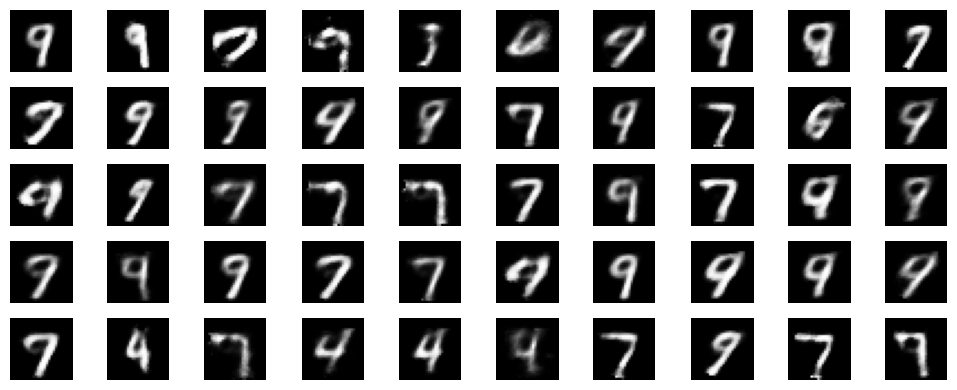

In [87]:
display_samples2(decoded_samples[0][:50], labels=None, n_rows=5, n_cols=10)